**In this kernel, the following is what I will be doing:**

    1. Understand the problem: We will look at each variable and do a philosophical analysis about their 
       meaning and importance for this problem
    2. Univariable study. We'll just focus on the dependent variable ('SalePrice') and try to know a 
       little bit more about it.
    3. Multivariate study. We'll try to understand how the dependent variable and independent variables relate.
    4. Basic cleaning. We'll clean the dataset and handle the missing data, outliers and categorical variables.
    5. Test assumptions. We'll check if our data meets the assumptions required by most multivariate techniques.

**Import Packages**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

import utils

In [2]:
%matplotlib inline

### Import Data

In [3]:
def wrangle_data(data_path):
    """Given a data - stored in a particular file-path - import
    and manipulate data set for easier analysis
    
    Parameters:
    -----------
    data_path : str
        File path to the data source
        
    Returns:
    --------
    df : pd.DataFrame
        A pandas DataFrame
    """
    
    # Import data (from csv file)
    df = pd.read_csv(data_path)
    
    # Drop `Multi-collinearity` features
    drop_cols = ["1stFlrSF", "YearBuilt", "TotRmsAbvGrd"]
    
    # Drop `low-and-high cardinality` features
    drop_cols.append("Id")
    
    # Find and drop features > 15% missing data
    percent_missing_data = (df.isna().sum() / df.isna().count()).sort_values(ascending=False)
    missing_data_cols = percent_missing_data[percent_missing_data > 0.15].index
    drop_cols.extend(missing_data_cols)
    
    # Drop obversations with NaN
#     df.dropna(inplace=True)
    
    
    # Drop Columns
    df.drop(columns=drop_cols, inplace=True)
    
    
    return df

In [4]:
df = wrangle_data("data/train.csv")
df.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


    How big is the data we are working with? How many observations and features (variables)
    are in the dataset?
    * 1,460 Observations
    * 81 features (variables) 🤔 (How am I going to explore all these features?)

In [5]:
df.shape

(1460, 71)

    What features (attributes) do we have? Are there any missing values?
    What about their data-types?

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 71 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearRemodAdd   1460 non-null   int64  
 17  RoofStyle      1460 non-null   object 
 18  RoofMatl

    In order to understand our data, we will look at each variable and try to understand its meaning
    and relevance to this problem.
    
    In order to have some discipline in my analysis, I've adopted the idea of creating a spreadsheet
    with the following columns:
    
    1. Variable: Variable name
    2. Type: Variable's type; either `numerical` - int, float or `categorical` - for categorical values
    3. Segment: Identification of the variable's segment. We define three possible segments: building, 
       space or location.
    4. Expectation: Our expectation about the variable influence in `SalePrice.` We can define a categorical
       scale of `High`, `Medium` or `Low`
    5. Conclusion: Our conclusions about the importance of the variable, after we give a quick look at the
       data. We can define a categorical scale of `High`, `Medium` or `Low`.
    6. Comments: Any general comments

Analyst found here - [Spreadsheet](https://docs.google.com/spreadsheets/d/1HXOq9GMguCRamvw5YH8CQJececkYsrNYrpygL_pMJ3M/edit?usp=sharing)

    After a subjective and research analysis of each variable's relevance to `SalePrice`,
    I ended up with the following features:

|Feature|Expectation|Comments|
|-------|-----------|-------|
|MSZoning|High|We'd expect the zoning classification to incluenece the price of a house. E.g. With all otherfactors constant, a home in commercial zoning would be priced differently from that in industrail zoning.|
|Neighborhood|High|Definitely, neighborhood affects the price of a house|
|OverallQual|High|Overall material and finish of a house matters in pricing|
|OverallCond|High|Overall condition matters in pricing too|
|1stFlrSF|High|First floor area basically tells us how big the house is in surface area, therefore, it matters|
|2ndFlrSF|High|Same as first floor area|
|GrLivArea|High|Same as the 1stFlrSF and 2ndFlrSF|
|HouseStyle|Medium|We'd expect a different in pricing between 1Story and 2Story building|
|TotBsmtSF|Medium|With all other factors constant, a house with a bigger basement would be more expensive|
|Bedroom|Medium|For obvious reasons, this matters|
|GarageCars|Medium|A house with a garage that can have more cars might be pricy|
|GarageArea|Medium|The bigger the garage area, the more cars can pack in it. There might be multi-collinearity here|
|PoolArea|Medium|The presense of a swimming pool hicks the house price|
|MiscFeature|Medium|Depending on the Misc Feature, the price might be influence or not|

### Explore

    First things first, we will perform `Univariate Analysis` to understand the dependent variable, `SalePrice`;
    we want to understand the price range, as well as the central measures of tendency (min, mean, max prices).
    We will want to understand the frequency distribution, how spread the prices are, etc.

**SalePrice**

In [7]:
sale_price = df['SalePrice']

# Min, Max, Median Price
sale_price.aggregate(['min', 'mean', 'median', 'max']).to_frame()

,SalePrice
min,34900.00000
mean,180921.19589
median,163000.00000
max,755000.00000


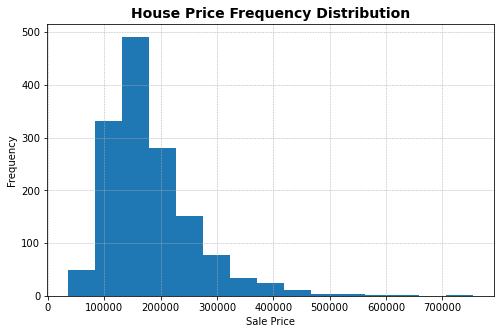

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))

# Histogram
sale_price.plot(kind='hist', bins=15)

# Title Properties
fontdict = {"fontsize": 14, "fontweight": "bold"}

# Labels
plt.title("House Price Frequency Distribution", fontdict=fontdict)
plt.xlabel("Sale Price")
plt.ylabel("Frequency")

# Add vertical lines
plt.grid(linestyle="--", linewidth=0.5)

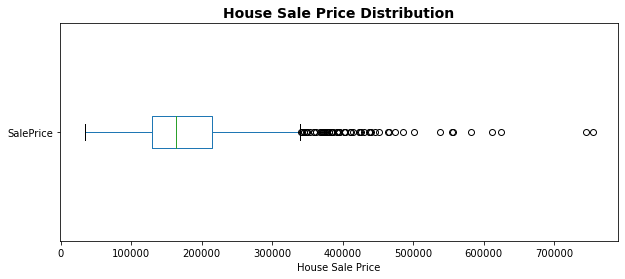

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))

# Boxplot
sale_price.plot(kind='box', vert=False)

# Labels
plt.title("House Sale Price Distribution", fontdict=fontdict)
plt.xlabel("House Sale Price");

In [10]:
print("Skewness:", round(sale_price.skew(), 2))
print("Kurtosis:", round(sale_price.kurt(), 2))

Skewness: 1.88
Kurtosis: 6.54


    Summary:
    
    * `SalePrice` is not normally distributed
    * It is skewed towards the right; there are houses with higher sale values present in our data;
      how will we deal with the outlier house prices present in the data ?🤔
    
    * 75% of houses where sold for less than ~USD225_000
    * 50% of houses where sold for a price between USD125_000 and USD225_000
    
    * A small number of houses were sold above USD700,000 
    

`Analyze Numerical Features`

**SalePrice vs TotalBsmtSF**

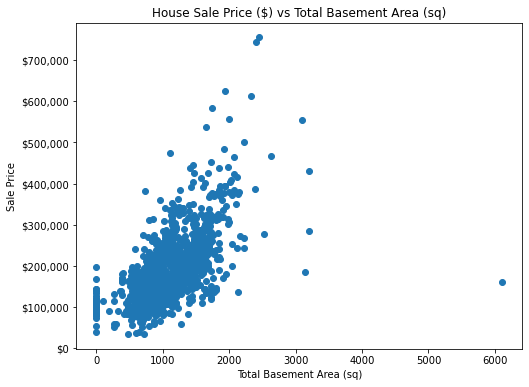

In [11]:
utils.plot_scatter_plot(
    x=df['TotalBsmtSF'], 
    y=sale_price, 
    title="House Sale Price ($) vs Total Basement Area (sq)",
    xlabel="Total Basement Area (sq)",
    ylabel="Sale Price"
)

In [12]:
print("Sale Price vs TotalBsmtSF Correlation:", round(sale_price.corr(df['TotalBsmtSF']), 2))

Sale Price vs TotalBsmtSF Correlation: 0.61


    Summary
    
    * A positive linear-relationship exists between sale price (USD) and total basement area (sq); As the total
    basement area increases, so does the house sale price. 
    * We observe one house whose total basement area was higher than the rest, but had a selling price close to
    USD200,000

**Sale Price vs 1stFlrSF**

In [13]:
# utils.plot_scatter_plot(
#     x=df['1stFlrSF'],
#     y=sale_price,
#     title="House Sale Price ($) vs First Floor (sq)",
#     xlabel="First Floor (sq)",
#     ylabel="Sale Price ($)"
# )

In [14]:
# print("Sale Price vs 1stFlrSF Correlation:", round(sale_price.corr(df['1stFlrSF']), 2))

    Summary
    
    * A positive linear-relationship exists between sale price and first floor (sq); the more first floor
    - in square feet - the more the house sale price.
    * We observe another house whose first floor (sq) was outlier and cost ~USD200,000. Is it the same house
    seen in the previous analysis?

In [15]:
# df[df['1stFlrSF'] > 4000][['Id', '1stFlrSF', 'TotalBsmtSF']]

    * Yep. Is's the same house

**Sale Price vs 2stFlrSF**

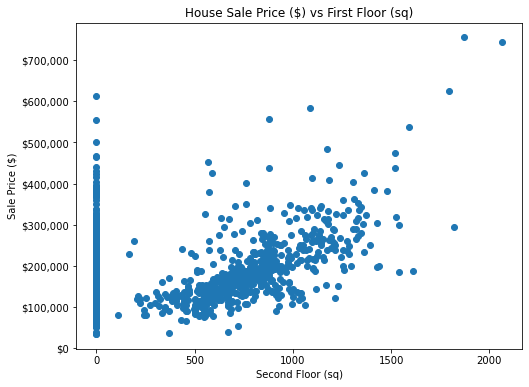

In [16]:
utils.plot_scatter_plot(
    x=df['2ndFlrSF'],
    y=sale_price,
    title="House Sale Price ($) vs First Floor (sq)",
    xlabel="Second Floor (sq)",
    ylabel="Sale Price ($)"
)

In [17]:
print("Sale Price vs 2ndFlrSF Correlation:", round(sale_price.corr(df['2ndFlrSF']), 2))

Sale Price vs 2ndFlrSF Correlation: 0.32


    Summary:
    
    * The scattter plot shows a positive linear-relationship between sale price and second floor (sq); 
    as the second floor area increases, so does the house selling price.
    * The correlation is at 0.32
    * We observe a number of houses whose second floor area (sq) is zero; perhaps these houses didn't have
    a second floor.

In [18]:
# Inspect Houses with a value of 0 on 2ndFlrSF
df[df['2ndFlrSF'] == 0].shape

(829, 71)

**Sale Price vs GrLivArea**

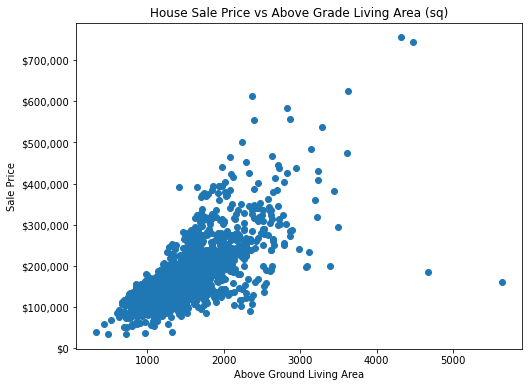

In [19]:
utils.plot_scatter_plot(
    x=df["GrLivArea"],
    y=sale_price,
    title="House Sale Price vs Above Grade Living Area (sq)",
    xlabel="Above Ground Living Area",
    ylabel="Sale Price"
)

In [20]:
print("Sale Price vs Above Ground Living Area Correlation:", round(sale_price.corr(df['GrLivArea']), 2))

Sale Price vs Above Ground Living Area Correlation: 0.71


    Summary:
    
    * Above Ground Living Area affects Sale Price such that as the area increases, so does the Sale Price; this
    indicated a positive linear-relationship between the two variables.
    * Again, the scatter plot shows outlier houses with an area above 4,500sq yet their sale price was less than
    USD200,000.

**Sale Price vs GarageArea**

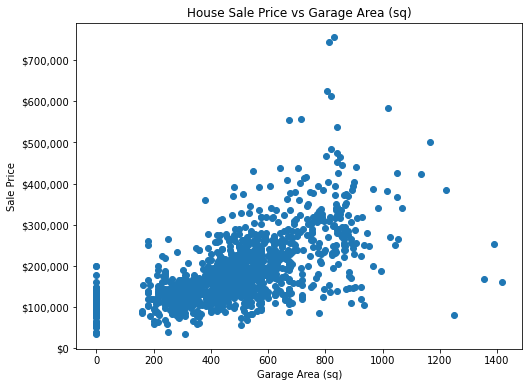

In [21]:
utils.plot_scatter_plot(
    x=df["GarageArea"],
    y=sale_price,
    title="House Sale Price vs Garage Area (sq)",
    xlabel="Garage Area (sq)",
    ylabel="Sale Price"
)

In [22]:
print("Correlation: Sale Price vs Garage Area:", round(sale_price.corr(df["GarageArea"]), 2))

Correlation: Sale Price vs Garage Area: 0.62


    Summary
    
    * Sale Price and Garage Area show a positive linear-relationship between them such that if the Sale Price
    increases as Garage Area (Space) increases.
    * A correlation of 0.62
    * Further, we observe a number of houses with Garage Area of 0; these might be houses that don't have a 
    garage.

**Sale Price vs PoolArea**

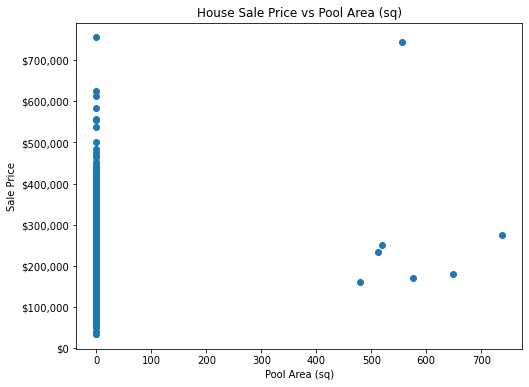

In [23]:
utils.plot_scatter_plot(
    x=df["PoolArea"],
    y=sale_price,
    title="House Sale Price vs Pool Area (sq)",
    xlabel="Pool Area (sq)",
    ylabel="Sale Price"
)

    Summary
    
    * Interestingly, the majority of houses don't have a swimming pool; this might be indicated by the presense
    of a zero as the value for the majority of houses.
    * No relationship occurs between these two variables

In [24]:
# df["PoolQC"].value_counts()

In [25]:
# df["PoolQC"].isnull().sum()

    * `PoolArea` contains 1,453 missing values; we drop this feature before fitting a model 🎯

`Analyze Categorical Features`

**Sale Price vs Neighborhood**

In [26]:
nghbrhood_counts = df["Neighborhood"].value_counts(normalize=True).sort_values()

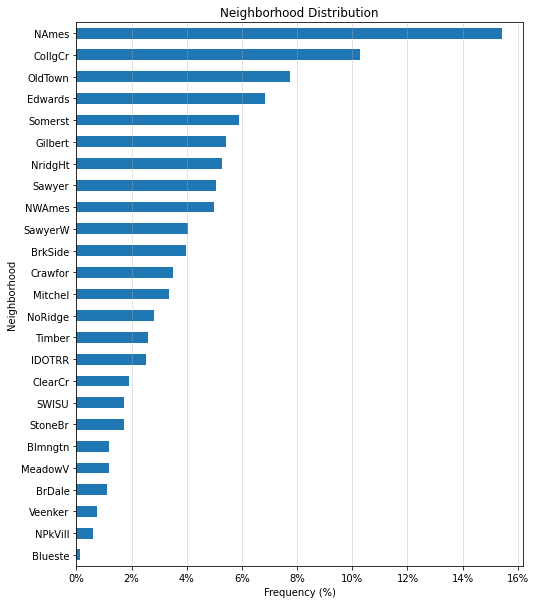

In [27]:
utils.plot_bar(
    data=nghbrhood_counts,
    title="Neighborhood Distribution",
    ylabel="Neighborhood",
    ticks_range=np.arange(0.0, 0.18, 0.02),
    labels=["0%", "2%", "4%", "6%", "8%", "10%", "12%", "14%", "16%"]
)

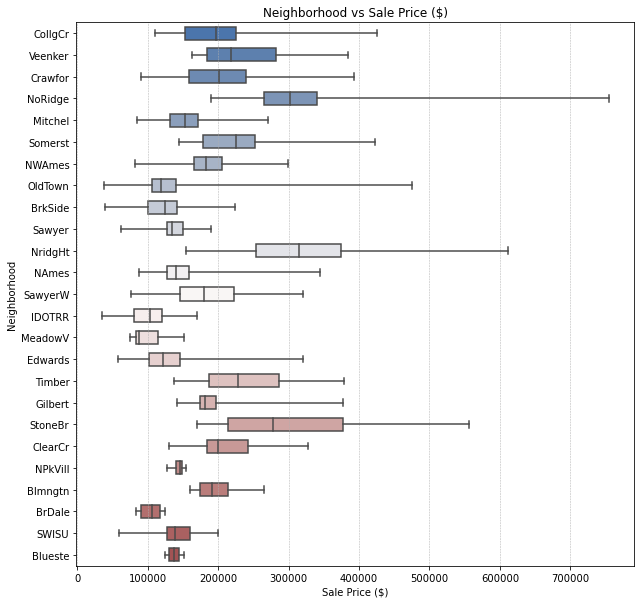

In [28]:
utils.plot_box(
    data=df, 
    x="SalePrice", 
    y="Neighborhood", 
    title="Neighborhood vs Sale Price ($)",
    xlabel="Sale Price ($)",
    ylabel="Neighborhood"
)

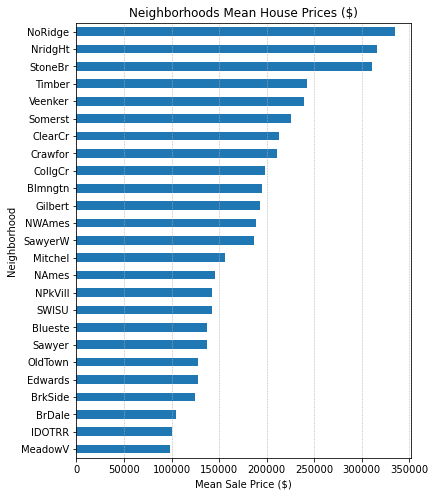

In [29]:
fig, ax = plt.subplots(figsize=(6, 8))

# Barplot
df.groupby(by="Neighborhood")["SalePrice"].mean().sort_values().plot(kind="barh")

# Labels
plt.title("Neighborhoods Mean House Prices ($)")
plt.ylabel("Neighborhood")
plt.xlabel("Mean Sale Price ($)")

# Add x-grid lines
plt.grid(axis="x", linewidth=0.5, linestyle="--");

    Summary
    
    * Neighborhood affects the sale price
    * Depending on the neighborhood a house is in, that neighborhood has a mean selling price; e.g. The avg
    selling price of a house in NoRidge - `Northridge` is close to USD350,000 where as that of a house in
    MeadowV `Meadow Village` is close to USD100,000.

**SalePrice vs HouseStyle**

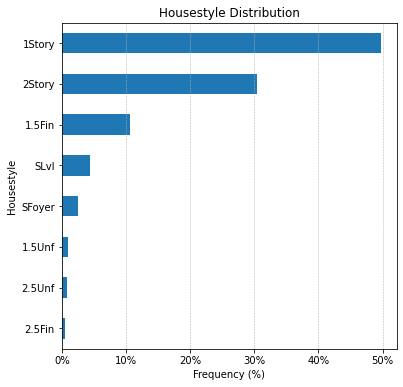

In [30]:
# What type of styles do the houses have?
housestyle = df["HouseStyle"].value_counts(normalize=True).sort_values()

utils.plot_bar(
    data=housestyle, 
    title="Housestyle Distribution", 
    ylabel="Housestyle",
    ticks_range=np.arange(0.0, round(housestyle.max() + 0.1, 2), 0.1),
    labels=["0%", "10%", "20%", "30%", "40%", "50%"],
    figsize=(6, 6)
)

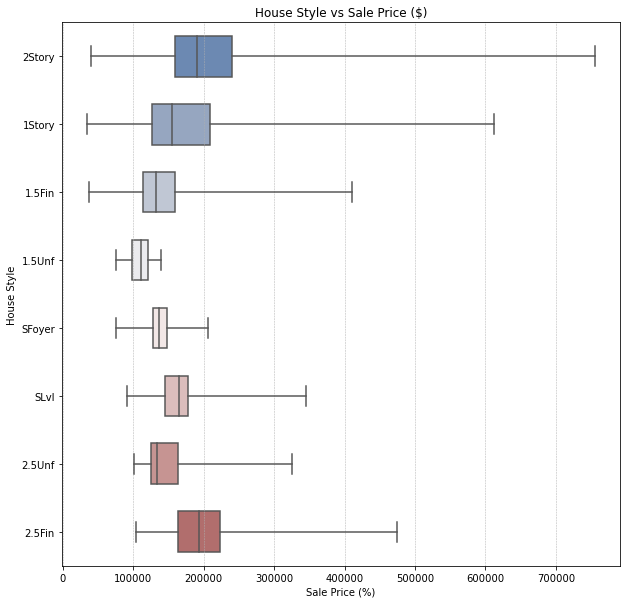

In [31]:
utils.plot_box(df, "SalePrice", "HouseStyle", "House Style vs Sale Price ($)", "Sale Price (%)", "House Style")

    Summary
    
    * It seems `House Style` also affects the Sale Price

**SalePrice vs OverallCond**

In [32]:
# Change dtype
df["OverallCond"] = df["OverallCond"].astype('category')

overall_cond = df["OverallCond"].value_counts(normalize=True).sort_values()
overall_cond

1    0.000685
2    0.003425
9    0.015068
3    0.017123
4    0.039041
8    0.049315
7    0.140411
6    0.172603
5    0.562329
Name: OverallCond, dtype: float64

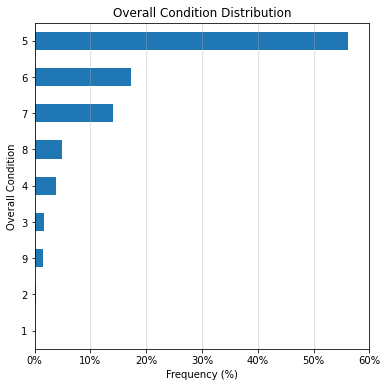

In [33]:
utils.plot_bar(
    overall_cond, 
    "Overall Condition Distribution",
    "Overall Condition",
    ticks_range=np.arange(0.0, overall_cond.max() + 0.1, 0.1),
    labels=["0%", "10%", "20%", "30%", "40%", "50%", "60%"],
    figsize=(6, 6)
)

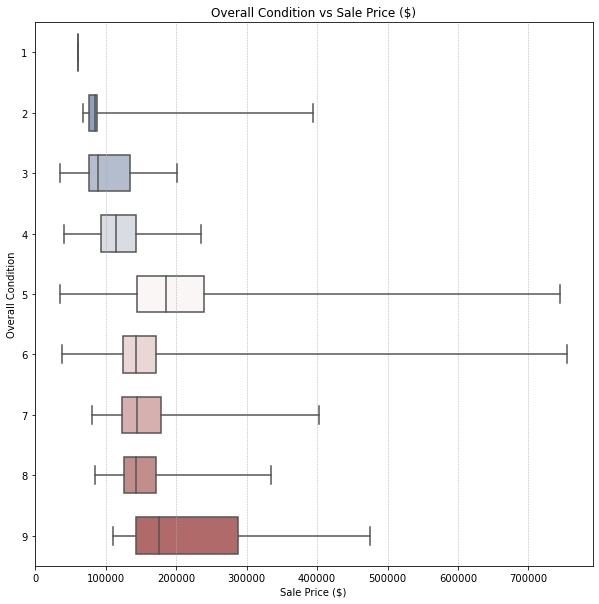

In [34]:
utils.plot_box(
    data=df, 
    y="OverallCond", 
    x="SalePrice", 
    title="Overall Condition vs Sale Price ($)", 
    xlabel="Sale Price ($)", 
    ylabel="Overall Condition"
)

    Summary
    
    * The better the house's condition, the higher the avg selling price

**SalePrice vs Bedroom**

In [35]:
df["BedroomAbvGr"] = df["BedroomAbvGr"].astype('category')

bedroom = df["BedroomAbvGr"].value_counts(normalize=True).sort_values()
bedroom

8    0.000685
0    0.004110
6    0.004795
5    0.014384
1    0.034247
4    0.145890
2    0.245205
3    0.550685
Name: BedroomAbvGr, dtype: float64

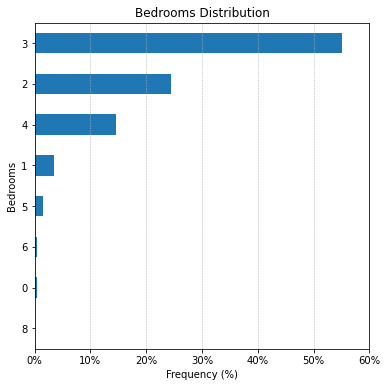

In [36]:
utils.plot_bar(
    bedroom, 
    "Bedrooms Distribution",
    "Bedrooms",
    ticks_range=np.arange(0.0, overall_cond.max() + 0.1, 0.1),
    labels=["0%", "10%", "20%", "30%", "40%", "50%", "60%"],
    figsize=(6, 6)
)

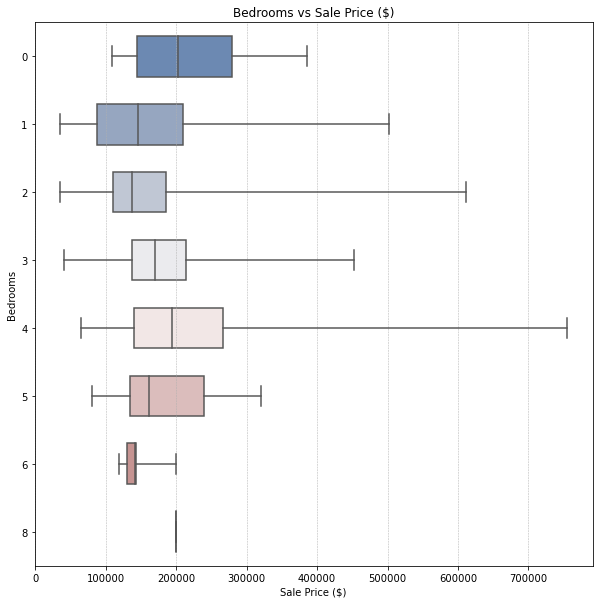

In [37]:
utils.plot_box(
    data=df, 
    y="BedroomAbvGr", 
    x="SalePrice", 
    title="Bedrooms vs Sale Price ($)", 
    xlabel="Sale Price ($)", 
    ylabel="Bedrooms"
)

    Summary
    
    * 75% of houses have 2 or 3 bedrooms above ground; 25% and 50% of the houses are 2-bedrooms and 3-bedrooms,
    respectively.
    * It looks like the number of bedrooms above ground doesn't really influence the house sale price.

**SalePrice vs GarageCars**

In [38]:
df["GarageCars"] = df["GarageCars"].astype("category")

garage_car_capacity = df["GarageCars"].value_counts(normalize=True).sort_values()
garage_car_capacity

4    0.003425
0    0.055479
3    0.123973
1    0.252740
2    0.564384
Name: GarageCars, dtype: float64

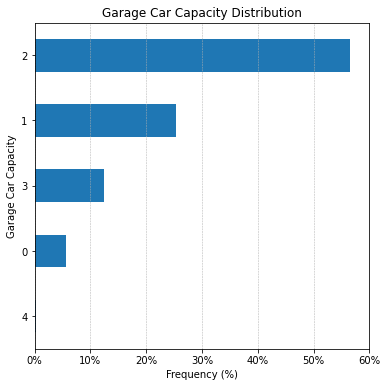

In [39]:
# Size of Garage (Car Capacity) Distribution
utils.plot_bar(
    garage_car_capacity, 
    "Garage Car Capacity Distribution",
    "Garage Car Capacity",
    ticks_range=np.arange(0.0, overall_cond.max() + 0.1, 0.1),
    labels=["0%", "10%", "20%", "30%", "40%", "50%", "60%"],
    figsize=(6, 6)
)

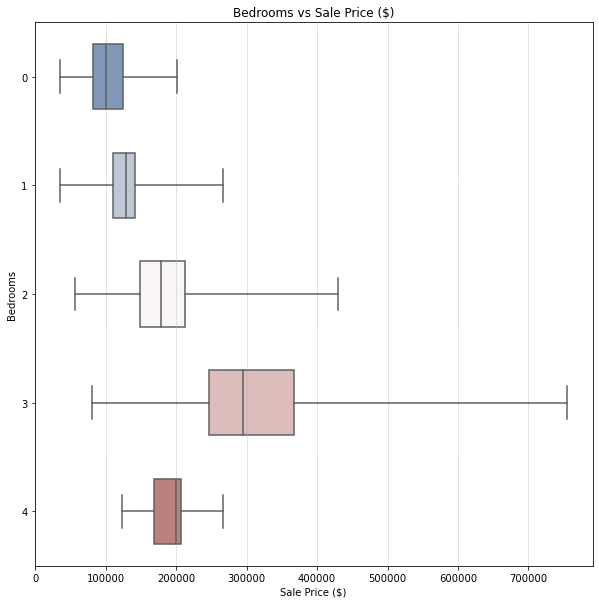

In [40]:
utils.plot_box(
    data=df, 
    y="GarageCars", 
    x="SalePrice", 
    title="Bedrooms vs Sale Price ($)", 
    xlabel="Sale Price ($)", 
    ylabel="Bedrooms"
)

    Summary
    
    * 50% of houses have a garage with a capacity of 2 cars
    * It seems the capacity of the garage influences the sale price of a house; however, we observe that
    as a house's garage car capacity increases from the 0 to 3, so does the sale price of the house.
    * In the visual, we see that the selling price of houses with a garage car capacity of 4 is slightly doesn't
    follow the trend; looking at the distribution, it looks more like there are not many houses with this
    car capacity and that which was available had a price that was slightly lower.

In [41]:
# Houses with a Garage Car Capacity of 4
df[df["GarageCars"] == 4]

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
420,90,RM,7060,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,...,0,0,0,0,0,11,2008,WD,Alloca,206300
747,70,RM,11700,Pave,IR1,Lvl,AllPub,Corner,Gtl,OldTown,...,386,0,0,0,0,5,2009,WD,Normal,265979
1190,190,RL,32463,Pave,Reg,Low,AllPub,Inside,Mod,Mitchel,...,0,0,0,0,0,3,2007,WD,Normal,168000
1340,20,RL,8294,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,6,2007,WD,Normal,123000
1350,90,RL,11643,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,0,8,2009,WD,Normal,200000


**Correlation Matrix**

    Here, we will explore the relationships in our data by calculating the correlation between them. This will
    enable us to see which features influence `SalePrice` and how, and which features are correlated with each
    other.

In [42]:
# Correlation
corr = df.corr()

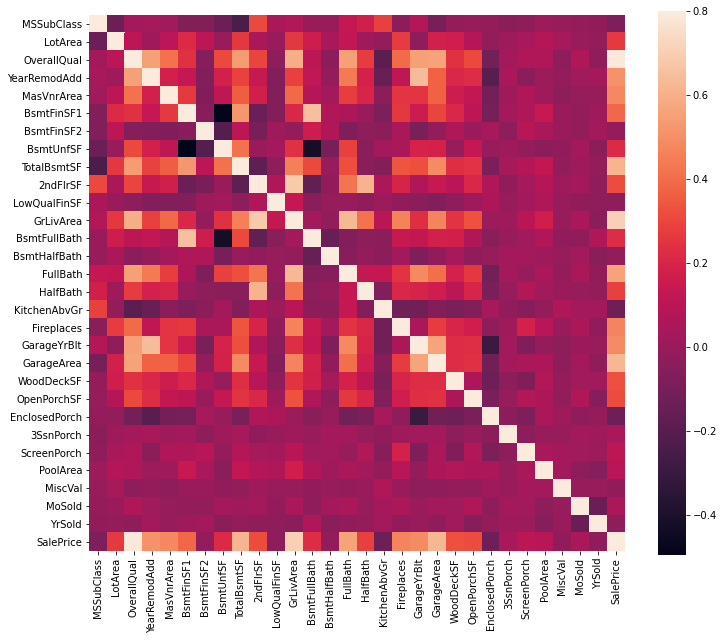

In [43]:
# Draw Axis
fig, ax = plt.subplots(figsize=(12, 10))

# HeatMap
sns.heatmap(corr, vmax=.8, square=True);

    Summary
    
    * From a first glass, we see that `TotalBsmtSF` and `1stFlrSF` are highly correlated with each other; 
    multi-collinearity exists here. We can drop-off the feature with the smallest correlation between the two.
    * We also observe multi-collinearity on the features `OverallQual` <> `YearBuilt.` This makes sense; the
    overall quality of a house correlates with the year it was built; we'd expect a house built in 2022 to be 
    of good quality compared that built in the year 1990.
    
    * We also observe that SalePrice is correlated with `OverallQual`, `TotalBsmtSF`, `GarageArea`, 
    and `GrLivArea` - features we identified in our initial analysis.

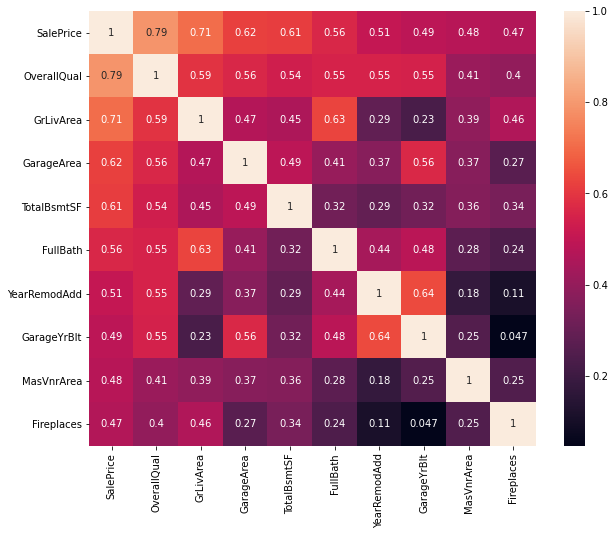

In [44]:
# Pick 10 highest correlated features
cols = corr.nlargest(10, 'SalePrice')["SalePrice"].index
# Calculate corr among those features
sale_price_top10_corr = df[cols].corr()

# Draw Axis
fig, ax = plt.subplots(figsize=(10, 8))
# Heatmap
sns.heatmap(sale_price_top10_corr, annot=True)
plt.show();

    The following are the 10 most correlated features:
    
    * `OverallQual`, `GrLivArea` and `GarageArea` are the most correlated features with `SalePrice`.
    * `GrLivArea` <> `TotRmsAbvGrd` and `TotalBsmtSF` <> `1stFlrSF` are correlated between themselves; this
    indicates multi-collinearity. Therefore, we remove the least correlated features to `SalePrice` in the
    pairs.

**Scatter plots between `SalePrice` and correlated variables**

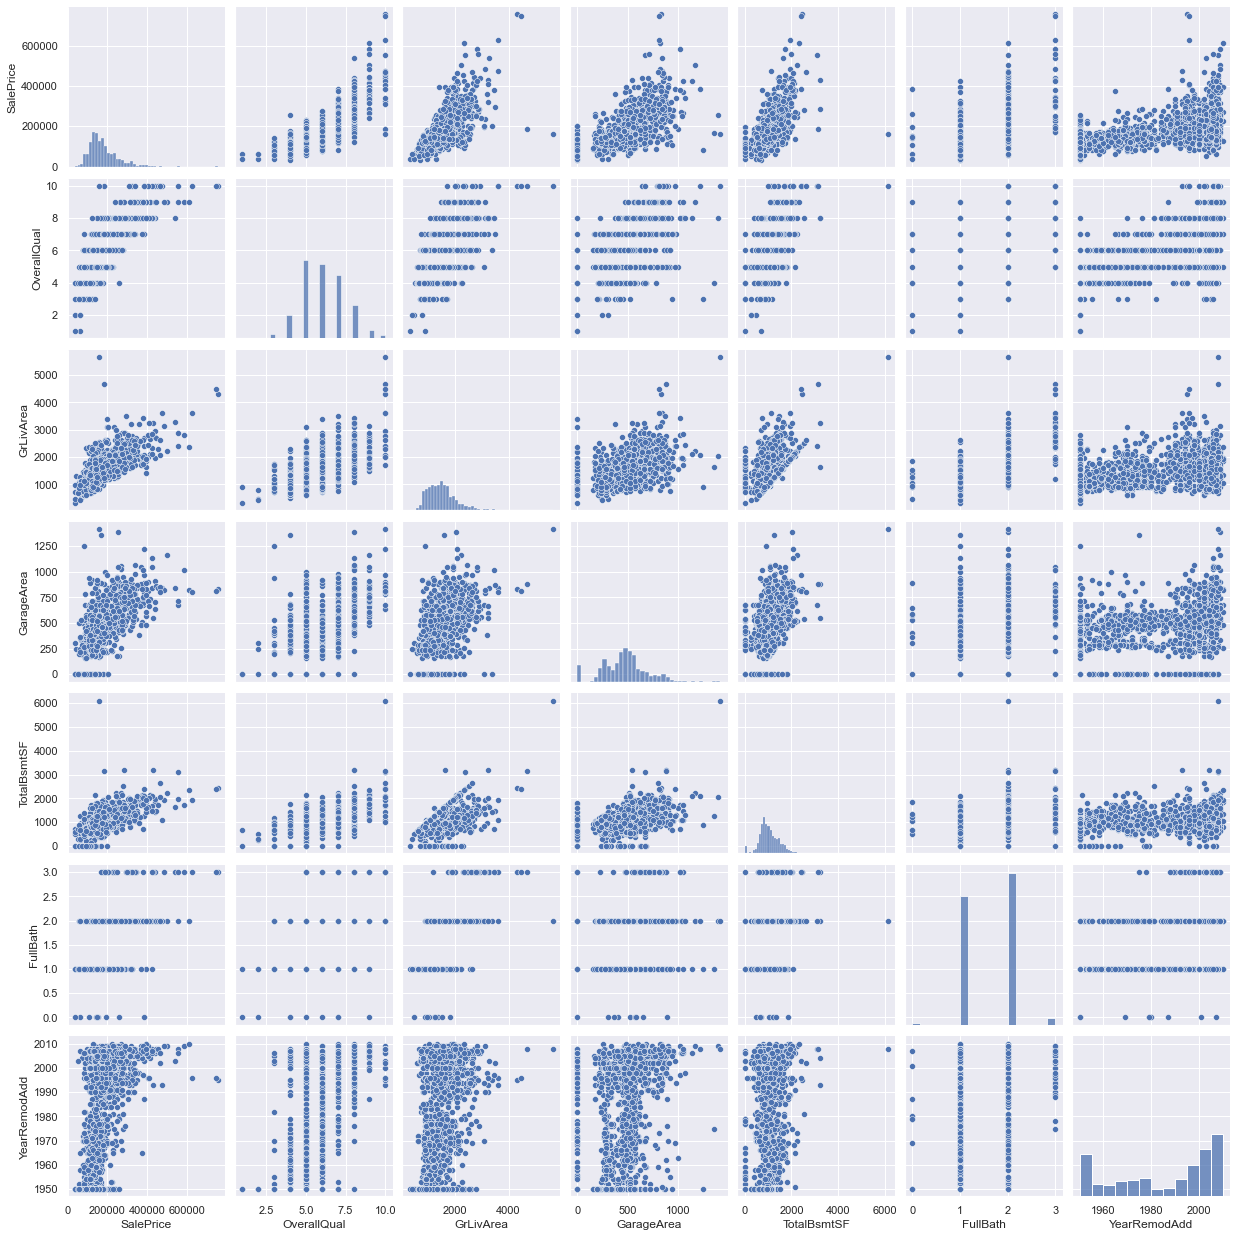

In [45]:
sns.set()

# Most correlated features
corr_feats = ["SalePrice", "OverallQual", "GrLivArea", "GarageArea", "TotalBsmtSF", "FullBath", "YearRemodAdd"]
# Pairplots
sns.pairplot(df[corr_feats]);

**Missing Data**

- How prevelant is the missing data?
- Is missing data random or does it have a pattern?

In [46]:
# Number of missing values per column
total = df.isna().sum().sort_values(ascending=False)
# Percent of missing values per column
percent = ((df.isna().sum() / df.isna().count())).sort_values(ascending=False)

# Missing Data: DF
missing_data = pd.DataFrame(data={
    "Total": total,
    "Percent": percent
})

missing_data.head(20)

,Total,Percent
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342
BsmtQual,37,0.025342


    Analysis
    
    * The features `PoolQC`, `MiscFeature`, `Alley`, etc have over 80% of the data missing; these features should
    be dropped from other data.
    * The garage features `GarageCond`, `GarageQual`, etc are missing 81 data points; it could be that the houses
    corresponding to these features didn't have a garage.
    * Same for the basement and masonry features.
    * Electical is only missing 1 data point, so we will remove this observations
    
    In general, if a feature has more than 15% of data missing, we will delete it. Otherwise, we will keep it,
    delete entries with those missing data points or try out imputation strategies.

In [47]:
# percent_missing_data = (df.isna().sum() / df.isna().count()).sort_values(ascending=False)
# missing_data_cols = percent_missing_data[percent_missing_data > 0.15].index
# df.drop(columns=missing_data_cols)

In [49]:
# df.dropna(inplace=True)